整理自 链接： https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html#sec-multi-armed-bandits


仿真一个简单的 multi-armed bandit 问题的实现，有五个动作，actions =[0,1,2,3,4]。

每个动作都有一个相关的概率: probabilities =[0.1,0.3,0.7,0.2,0.1]。

模拟对一个 bandit 问题运行 2000 个回合，每个回合有 1000 步。

在每一步中，代理必须选择一个动作。对于它选择的动作 $a$，它获得奖励为 5 的概率为概率 probability[a]。

它得到的奖励为 0 的概率为 1 -probability[a]。

在每个回合的开始，bandit 的策略被重置。


## 表格环境 模块

In [5]:
#######  DeterministicPolicy
class Policy:
    def select_action(self, state, action):
        abstract


class DeterministicPolicy(Policy):
    def update(self, state, action):
        abstract


class StochasticPolicy(Policy):
    def update(self, states, actions, rewards):
        abstract

    def get_probability(self, state, action):
        abstract



####### TabularPolicy
import random
from collections import defaultdict
# from policy import DeterministicPolicy


class TabularPolicy(DeterministicPolicy):
    def __init__(self, default_action=None):
        self.policy_table = defaultdict(lambda: default_action)

    def select_action(self, state, actions):
        return self.policy_table[state]

    def update(self, state, action):
        self.policy_table[state] = action


#######  QFunction

# from tabular_policy import TabularPolicy


class QFunction:

    """ Update the Q-value of (state, action) by delta """

    def update(self, state, action, delta):
        abstract

    """ Get a Q value for a given state-action pair """

    def get_q_value(self, state, action):
        abstract

    """ Save a policy to a specified filename """
    def save_policy(self, filename):
        abstract

    """ Load a policy from a specified filename """
    def load_policy(self, filename):
        abstract

    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q

    """ Return the maximum Q-value in this Q-function """
    def get_max_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return max_q

    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        arg_max_q = None
        max_q = float("-inf")
        for action in actions:
            value = self.get_q_value(state, action)
            if max_q < value:
                arg_max_q = action
                max_q = value
        return (arg_max_q, max_q)



#######  QTable

import json
from collections import defaultdict
# from qfunction import QFunction


class QTable(QFunction):
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def get_q_values(self, states, actions):
        return [self.get_q_value(state, action) for state, action in zip(states, actions)]

    def save(self, filename):
        with open(filename, "w") as file:
            serialised = {str(key): value for key, value in self.qtable.items()}
            json.dump(serialised, file)

    def load(self, filename, default=0.0):
        with open(filename, "r") as file:
            serialised = json.load(file)
            self.qtable = defaultdict(
                lambda: default,
                {tuple(eval(key)): value for key, value in serialised.items()},
            )



## 探索 与 利用 仿真测试

In [6]:
from collections import defaultdict
import random
# from qtable import QTable

# 运行一个 具有一定回合数，一定步长的 bandit 算法

def run_bandit(bandit, episodes=200, episode_length=500, drift=True): # drift 是否回合中途改奖励概率
  # 有效动作 集
  actions = [0, 1, 2, 3, 4]

  # dummy 状态
  state = 1

  rewards = []
  for _ in range(0, episodes):
    bandit.reset()

    # 每个动作获得回报为 1 的概率
    probabolities = [0.1, 0.3, 0.7, 0.2, 0.1]

    # 每个 arm 已被选择的次数
    times_selected = defaultdict(lambda : 0)
    qtable = QTable()

    episode_rewards = []
    for step in range(0, episode_length):
      # 回合进行到一半， 改变概率
      if drift and step == episode_length / 2:
        probabolities = [0.5, 0.2, 0.0, 0.3, 0.3]

      # 使用 bandit 选择一个动作
      action = bandit.select(state, actions, qtable)

      # 获得 该动作的奖励
      reward = 0
      if random.random() < probabolities[action]:
        reward = 5

      episode_rewards += [reward]
      times_selected[action] = times_selected[action] + 1

      qtable.update(
          state,
          action,
          (reward / times_selected[action])
          - (qtable.get_q_value(state, action) / times_selected[action]),
      )
    rewards += [episode_rewards]

  return rewards


### 1、$\epsilon$-greedy 策略


参数 $\epsilon\in[0,1]$ 控制 探索 和 利用的程度。

* 以 $1-\epsilon$  的概率 选择具有 最大 Q 值的动作 $\arg\max_a Q(a)$ (**利用**)。如果具有最大 Q 值的动作有好几个，则随机选一个
* 以 $\epsilon$  的概率 随机选择其中一个。(探索)

通常  $\epsilon\in[0.05,0.2]$ 比较好



In [7]:
import random
# from multi_armed_bandit.multi_armed_bandit import MultiArmedBandit

class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        abstract

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()


#######################
class EpsilonGreedy(MultiArmedBandit):
  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon

  def reset(self):
    pass

  def select(self, state, actions, qfunction):
    # 以 epsilon 的概率 随机选择一个动作 0.05-0.2
    if random.random() < self.epsilon:
      return random.choice(actions)
    arg_max_q = qfunction.get_argmax_q(state, actions)
    return arg_max_q


##### 绘图模块


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math


class Plot:

    # mean rewards over a window
    DEFAULT_WINDOW_SIZE = 250

    # Background colour for a plot
    BACKGROUND_COLOUR = "#EAEAEA"

    """
    Calculate the mean reward per episode over a set of episodes
    """

    def get_mean_step_rewards(runs):
        num_runs, num_episodes = len(runs), len(runs[0])
        max_num_steps = 0
        for run in runs:
            for episode in run:
                if len(episode) > max_num_steps:
                    max_num_steps = len(episode)

        mean_reward_episodes = [
            [0 for j in range(max_num_steps)] for i in range(num_episodes)
        ]

        # calculate the mean reward for each episode in each run
        for episode in range(num_episodes):
            num_steps = 0
            for run in range(num_runs):
                if len(runs[run][episode]) > num_steps:
                    num_steps = len(runs[run][episode])

            for step in range(num_steps):
                step_rewards = []
                for run in range(num_runs):
                    if step < len(runs[run][episode]):
                        step_rewards += [runs[run][episode][step]]
                mean_reward_episodes[episode][step] = np.mean(step_rewards)

        return mean_reward_episodes

    """
    Calculate the mean and stddev reward per step over all episodes of a simulation.
    """

    def get_mean_rewards_per_step_old(rewards):
        mean_rewards = []
        # calculate the mean reward for each step in an episode
        for step in range(len(rewards[0])):
            sum = 0.0
            for episode in range(len(rewards)):
                sum += rewards[episode][step]
            mean_rewards += [sum / len(rewards)]
        return mean_rewards

    def get_mean_rewards_per_step(rewards):
        mean_rewards = []
        stddev_rewards = []

        # transpose the matrix
        columns = [list(column) for column in zip(*rewards)]

        # calculate sum and variance of each column (of original matrix)
        for column in columns:
            mean = sum(column) / len(column)
            variance = sum((reward - mean) ** 2 for reward in column) / len(column)
            mean_rewards += [mean]
            stddev_rewards += [math.sqrt(variance)]
        return (mean_rewards, stddev_rewards)

    """
        Calculate the mean reward for each episode,
        averaging the last 'window_size' number of episodes
    """

    def get_mean_rewards_per_episode(rewards, window_size=DEFAULT_WINDOW_SIZE):
        summed_rewards = []

        for episode in rewards:
            summed_rewards += [sum(episode)]

        mean_rewards = []
        for i in range(len(summed_rewards)):
            window = summed_rewards[max(0, i - window_size) : i + 1]
            mean_rewards += [sum(window) / len(window)]
        return mean_rewards

    """
        Calculate the exponential moving mean of a list of rewards
    """

    def get_ema(rewards, smoothing_factor=0.9):
        smoothed_rewards = []
        for reward in rewards:
            if smoothed_rewards == []:
                smoothed_rewards = [reward]
            else:
                smoothed_rewards += [
                    smoothed_rewards[-1] * smoothing_factor
                    + reward * (1 - smoothing_factor)
                ]
        return smoothed_rewards

    """
        Calculate the length of each episode
    """

    def get_episode_length(rewards):
        episode_lengths = []

        # Omit the first episode as it is (usually) random
        for episode in rewards[1:]:
            episode_lengths += [len(episode)]

        return episode_lengths

    """
    Plot the rewards per step of several methods.
    """

    def plot_rewards(labels, reward_list, smoothing_factor=0.9):
        x = np.linspace(0, len(reward_list[0][0]), len(reward_list[0][0]))
        index = 0
        linestyles = ["--", "-", ":", "-."]
        for rewards in reward_list:
            (mean_y, stddev_y) = Plot.get_mean_rewards_per_step(rewards)
            mean_smoothed = Plot.get_ema(mean_y, smoothing_factor=smoothing_factor)
            plt.plot(
                x,
                mean_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )

            index += 1

        plt.xlabel("Step")
        plt.ylabel("mean reward per step")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    def plot_cumulative_rewards(
        labels, reward_list, smoothing_factor=0.95, episodes_per_evaluation=1
    ):
        x = np.linspace(0, len(reward_list[0]), len(reward_list[0]))
        index = 0
        linestyles = ["-", "--", ":", "-."]
        for rewards in reward_list:
            y_smoothed = Plot.get_ema(rewards, smoothing_factor=smoothing_factor)
            plt.plot(
                x * episodes_per_evaluation,
                y_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("Cumulative reward")
        plt.legend(loc='upper left')
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    """
    Plot the rewards per episode of several methods.
    """

    def plot_rewards_per_episode(labels, reward_list, window_size=DEFAULT_WINDOW_SIZE):
        index = 0
        linestyles = ["--", "-", ":", "-."]
        for rewards in reward_list:
            y = Plot.get_mean_rewards_per_episode(rewards, window_size=window_size)
            x = np.linspace(0, len(y), len(y))
            y_smoothed = y  # Plot.get_ema(y)
            plt.plot(
                x,
                y_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("mean reward per episode")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    """
    Plot the rewards per episode of several runs of the same method -
    don't distinguish between lines.
    """

    def plot_multirun_rewards_per_episode(reward_list, method_label):
        index = 0
        for rewards in reward_list:
            y = Plot.get_mean_rewards_per_episode(rewards)
            x = np.linspace(0, len(y), len(y))
            y_smoothed = Plot.get_ema(y)
            plt.plot(x, y_smoothed, color="#2222aa")
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("Av reward per ep - {0}".format(method_label))
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    """
    Plot the mean length of episode.
    """

    def plot_episode_length(labels, reward_list):
        index = 0
        linestyles = ["--", "-", ":", "-."]
        for rewards in reward_list:
            y = Plot.get_episode_length(rewards)
            x = np.linspace(0, len(y), len(y))
            y_smoothed = Plot.get_ema(y)
            plt.plot(
                x,
                y_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("Episode length")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()


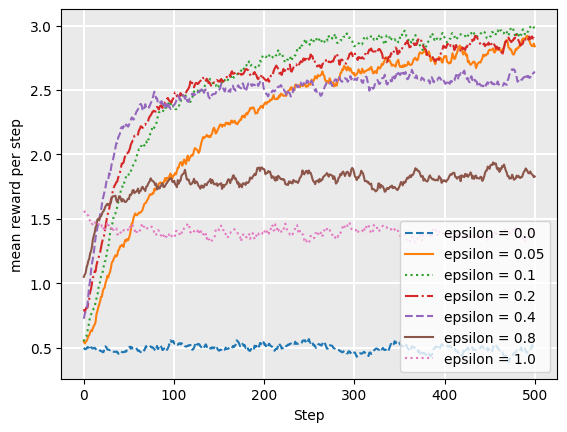

In [9]:
# 2000 个回合， 步长为 1000

# from multi_armed_bandit.epsilon_greedy import EpsilonGreedy
# from tests.multi_armed_bandit_tests.run_bandit import run_bandit
# from tests.plot import Plot

def plot_epsilon_greedy(drift=False):
  epsilon000 = run_bandit(EpsilonGreedy(epsilon=0.00), drift=drift)
  epsilon005 = run_bandit(EpsilonGreedy(epsilon=0.05), drift=drift)
  epsilon01 = run_bandit(EpsilonGreedy(epsilon=0.1), drift=drift)
  epsilon02 = run_bandit(EpsilonGreedy(epsilon=0.2), drift=drift)
  epsilon04 = run_bandit(EpsilonGreedy(epsilon=0.4), drift=drift)
  epsilon08 = run_bandit(EpsilonGreedy(epsilon=0.8), drift=drift)
  epsilon10 = run_bandit(EpsilonGreedy(epsilon=1.0), drift=drift)

  Plot.plot_rewards(
      [
          "epsilon = 0.0",
          "epsilon = 0.05",
          "epsilon = 0.1",
          "epsilon = 0.2",
          "epsilon = 0.4",
          "epsilon = 0.8",
          "epsilon = 1.0",

      ],
      [epsilon000, epsilon005, epsilon01, epsilon02, epsilon04, epsilon08, epsilon10],
  )

plot_epsilon_greedy()

当 $\epsilon$ 非 0 时， 一定步长内，  $\epsilon$ 越大，奖励平均值越大。


超过一定步长后， $\epsilon$ 越大，奖励平均值反而越小。因为花费额外的步长探索了一些 不太有价值 的动作。

### 2、$\epsilon$-decreasing  策略


开始时，收集的信息少，应该优先探索；
等收集的信息达到一定量时，再利用。

引入 参数  $\alpha\in[0,1]$， 用于让  $\epsilon$  随时间递减，该参数也称为  decay。

$\epsilon := \epsilon \times \alpha$

同样 以 $\epsilon$ 的概率 探索； 以 $1-\epsilon$ 的概率 利用。




获得更多反馈后，减少探索。

In [10]:
# from multi_armed_bandit.multi_armed_bandit import MultiArmedBandit
# from multi_armed_bandit.epsilon_greedy import EpsilonGreedy


class EpsilonDecreasing(MultiArmedBandit):
  def __init__(self, epsilon=1.0, alpha=0.999, lower_bound=0.1):
    self.epsilon_greedy_bandit = EpsilonGreedy(epsilon)
    self.initial_epsilon = epsilon
    self.alpha = alpha
    self.lower_bound = lower_bound

  def reset(self):
    self.epsilon_greedy_bandit = EpsilonGreedy(self.initial_epsilon)

  def select(self, state, actions, qfunction):
    result = self.epsilon_greedy_bandit.select(state, actions, qfunction)
    self.epsilon_greedy_bandit.epsilon = max(
        self.epsilon_greedy_bandit.epsilon * self.alpha, self.lower_bound
    ) # 需要一个非 0 下界，由上述的 epsilon-greedy 分析可知，值为 0 时效果不好
    return result



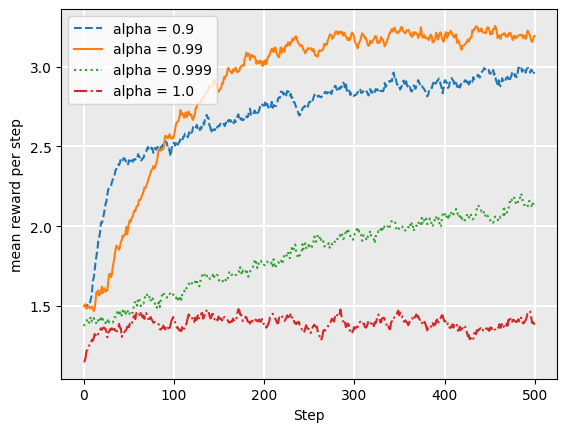

In [11]:
# α 对平均奖励的影响

# from multi_armed_bandit.epsilon_decreasing import EpsilonDecreasing
# from tests.multi_armed_bandit_tests.run_bandit import run_bandit
# from tests.plot import Plot

def plot_epsilon_decreasing(drift=False):
  alpha09 = run_bandit(EpsilonDecreasing(alpha=0.9), drift=drift)
  alpha099 = run_bandit(EpsilonDecreasing(alpha=0.99), drift=drift)
  alpha0999 = run_bandit(EpsilonDecreasing(alpha=0.999), drift=drift)
  alpha1 = run_bandit(EpsilonDecreasing(alpha=1.0), drift=drift)

  Plot.plot_rewards(
      [
          "alpha = 0.9",
          "alpha = 0.99",
          "alpha = 0.999",
          "alpha = 1.0"

      ],
      [alpha09, alpha099, alpha0999, alpha1],
  )

plot_epsilon_decreasing()


alpha 的选择既取决于特定的问题，也取决于每个回合的预期长度：对于较长的回合，减小缓慢些会更有益，这样我们不会过早地停止探索。

### 3、Softmax  策略

$\frac{e^{\frac{Q(a)}{\tau}}}{\sum\limits_{b=1}^Ne^{\frac{Q(b)}{\tau}}}$

In [12]:
import math
import random
# from multi_armed_bandit.multi_armed_bandit import MultiArmedBandit

class Softmax(MultiArmedBandit):
  def __init__(self, tau=0.1):
    self.tau = tau

  def reset(self):
    pass

  def select(self, state, actions, qfunction):
    # 计算 分母
    total = 0.0
    for action in actions:
      total += math.exp(qfunction.get_q_value(state, action)/ self.tau)

    rand = random.random()
    cumulative_probability = 0.0
    result = None
    for action in actions:
      probability = (
          math.exp(qfunction.get_q_value(state, action)/ self.tau) / total
      )

      if cumulative_probability <= rand <= cumulative_probability + probability:
        result = action

      cumulative_probability += probability

    return result

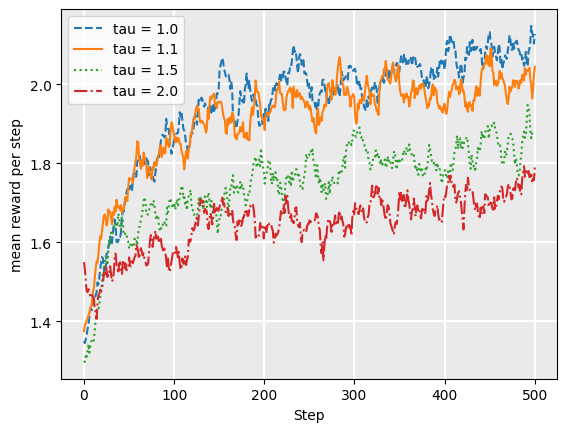

In [13]:
# 每一步的 平均奖励。 α

# from multi_armed_bandit.softmax import Softmax
# from tests.multi_armed_bandit_tests.run_bandit import run_bandit
# from tests.plot import Plot

def plot_softmax(drift=False):
  tau10 = run_bandit(Softmax(tau=1.0), drift=drift)
  tau11 = run_bandit(Softmax(tau=1.1), drift=drift)
  tau15 = run_bandit(Softmax(tau=1.5), drift=drift)
  tau20 = run_bandit(Softmax(tau=2.0), drift=drift)

  Plot.plot_rewards(
      ["tau = 1.0", "tau = 1.1","tau = 1.5", "tau = 2.0"],
      [tau10, tau11, tau15, tau20],
  )

plot_softmax(drift=False)

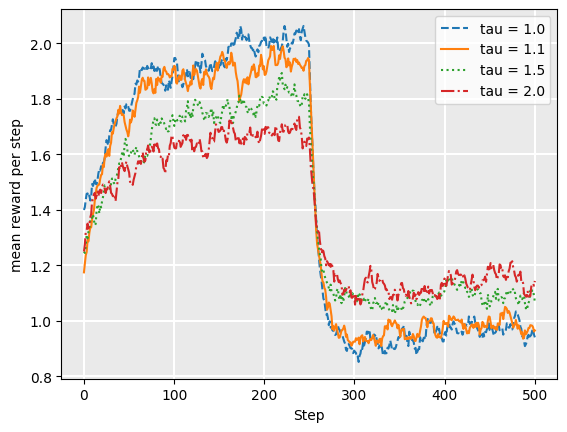

In [14]:
# 回合 中间 改变 概率分布
# probabilities = [0.1, 0.3, 0.7, 0.2, 0.1] to probabilities = [0.5, 0.2, 0.0, 0.3, 0.3].

plot_softmax(drift=True)

### 4、Upper Confidence Bounds (UCB1)

$\arg\max_a\Big(Q(a)+\sqrt{\frac{2\ln t}{N(a)}}\Big)$





In [15]:
import math
import random
# from multi_armed_bandit.multi_armed_bandit import MultiArmedBandit

class UpperConfidenceBounds(MultiArmedBandit):
  def __init__(self):
    self.total = 0
    # 每个动作已经被选择的次数
    self.times_selected = {}

  def select(self, state, actions, qfunction):
    # 将 每个 动作 先执行一次， 避免 N(a) 为 0
    for action in actions:
      if action not in self.times_selected.keys():
        self.times_selected[action] = 1
        self.total += 1
        return action

    max_actions = []
    max_value = float("-inf")
    for action in actions:
      value = qfunction.get_q_value(state, action) + math.sqrt(
          (2 * math.log(self.total))/self.times_selected[action]
      ) # Python 的 math.log 默认以 e 为底

      if value > max_value:
        max_value = value
        max_actions = [action]

      elif value == max_value:
        max_actions += [action]

    # 如果 有 多个动作 具有最高值
    # 随机选择其中一个
    result = random.choice(max_actions)
    self.times_selected[result] = self.times_selected[result] + 1
    self.total += 1
    return result


### ——比较

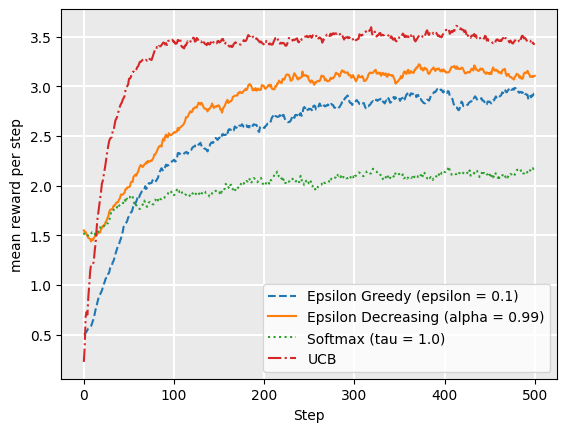

In [17]:
# from multi_armed_bandit.epsilon_greedy import EpsilonGreedy
# from multi_armed_bandit.epsilon_decreasing import EpsilonDecreasing
# from multi_armed_bandit.softmax import Softmax
# from multi_armed_bandit.ucb import UpperConfidenceBounds
# from tests.multi_armed_bandit_tests.run_bandit import run_bandit
# from tests.plot import Plot

def plot_comparison(drift=False):
  epsilon_greedy = run_bandit(EpsilonGreedy(epsilon=0.1), drift=drift)
  epsilon_decreasing = run_bandit(EpsilonDecreasing(alpha=0.99), drift=drift)
  softmax = run_bandit(Softmax(tau=1.0), drift=drift)
  ucb = run_bandit(UpperConfidenceBounds(), drift=drift)

  Plot.plot_rewards(
      [
          "Epsilon Greedy (epsilon = 0.1)",
          "Epsilon Decreasing (alpha = 0.99)",
          "Softmax (tau = 1.0)",
          "UCB",
      ],
      [epsilon_greedy, epsilon_decreasing, softmax, ucb],
  )

plot_comparison(drift=False)

平均而言，UCB1 在模拟中获得的奖励最高。

如果我们将模拟回合延长，我们将看到最终 $\epsilon$-decreasing   将开始获得与 UCB1 相似的奖励，但它需要更长的时间才能收敛。

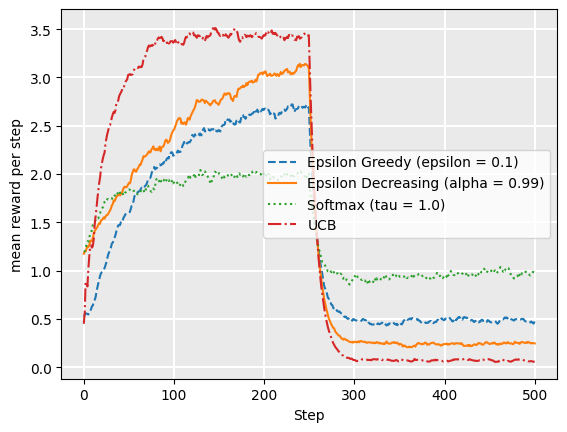

In [18]:
plot_comparison(drift=True)


$\epsilon$-decreasing  策略只适用于**静态问题**。


如果潜在的**概率分布有规律地变化或漂移**，softmax 可能是一个更好的选择。